In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits_cr import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_full_with_cr_3days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_with_cr_3days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_with_cr_3days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

271
302
417
422
318


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )

        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear((hidden_size*2) + 2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),

        )

    def forward(self, images, kp) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)
        image_features = image_features[:, -1, :]
        kp = kp.reshape(batch_size, 1)
        kp = kp.repeat(1, 2)
        image_features = torch.cat((image_features, kp), dim=1)
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels, p_Kp) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()

              # Forward pass with autograd
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels, p_Kp in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  p_Kp = p_Kp.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images, p_Kp).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              p_Kp = p_Kp.float()
              # print("Label: ", labels)
              outputs = model(images, p_Kp).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2831524444458124


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.586463761679313


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5091565512972376


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.503564381644577


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2343706858958672


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5907394093208491


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.961106437235431


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8537744869544206


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7388717938170786


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8250992700969886


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7537251283611692


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.949537758349135


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6032870552475259


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.180952807820639


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.46519009779082243


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.949589006352128


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4337288857064823


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8871268444521334


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.34771481073709964


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7933690085080884


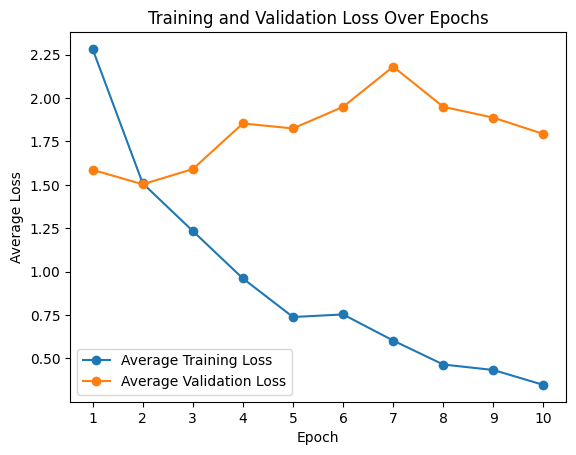

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.7934
RMSE: 1.3392
MSE: 1.7939
MAE: 1.0231
R²: -0.0644
R: 0.2980
True Skill Score: 0.3886
Accuracy: 0.7530
Precision: 0.5000
Recall: 0.3395
F1 Score: 0.4044


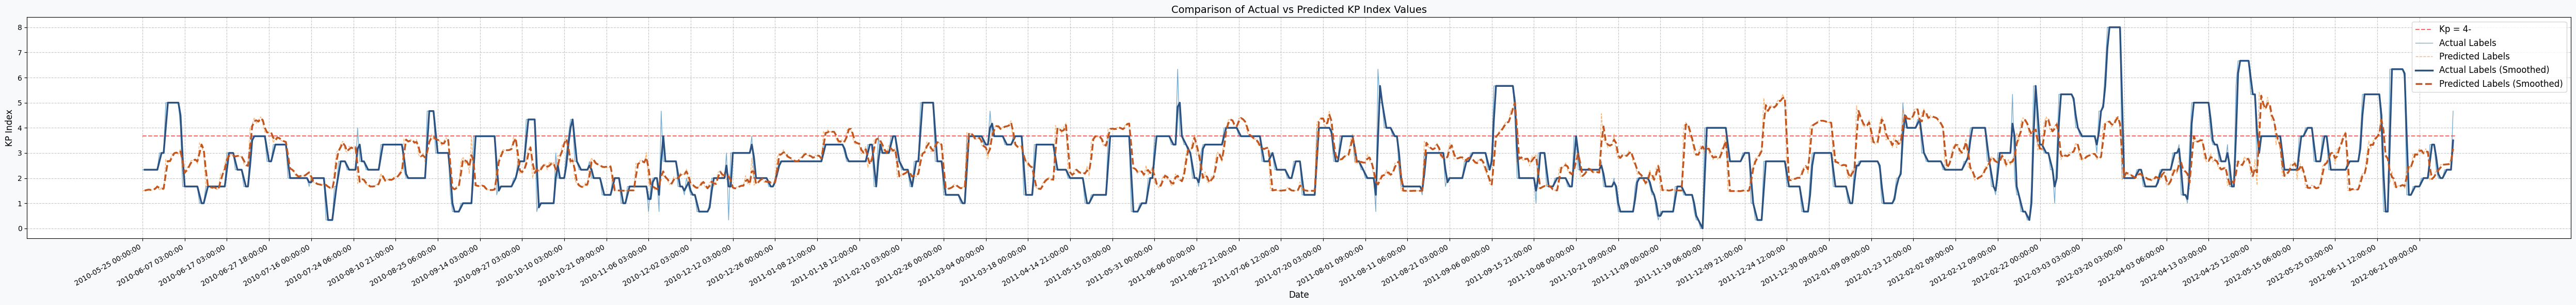

[np.float32(1.5), np.float32(1.5078125), np.float32(1.546875), np.float32(1.5390625), np.float32(1.515625), np.float32(1.5390625), np.float32(1.6171875), np.float32(1.703125), np.float32(1.515625), np.float32(1.6328125), np.float32(1.53125), np.float32(2.75), np.float32(2.609375), np.float32(2.734375), np.float32(2.9375), np.float32(3.03125), np.float32(3.0), np.float32(2.953125), np.float32(3.15625), np.float32(2.1875), np.float32(2.234375), np.float32(2.390625), np.float32(2.515625), np.float32(2.703125), np.float32(2.703125), np.float32(2.765625), np.float32(2.5625), np.float32(3.40625), np.float32(3.265625), np.float32(3.015625), np.float32(1.65625), np.float32(1.71875), np.float32(1.6015625), np.float32(1.6328125), np.float32(1.640625), np.float32(1.546875), np.float32(1.578125), np.float32(2.171875), np.float32(2.140625), np.float32(2.5625), np.float32(2.859375), np.float32(2.90625), np.float32(2.953125), np.float32(2.859375), np.float32(2.859375), np.float32(2.90625), np.float32

Testing Progress:   0%|          | 0/136 [00:00<?, ?it/s]

Average test loss: 3.3977
RMSE: 1.8433
MSE: 3.4088
MAE: 1.4613
R²: -2.2901
R: -0.0101
True Skill Score: 0.0000
Accuracy: 0.3395
Precision: 1.0000
Recall: 0.3395
F1 Score: 0.5069


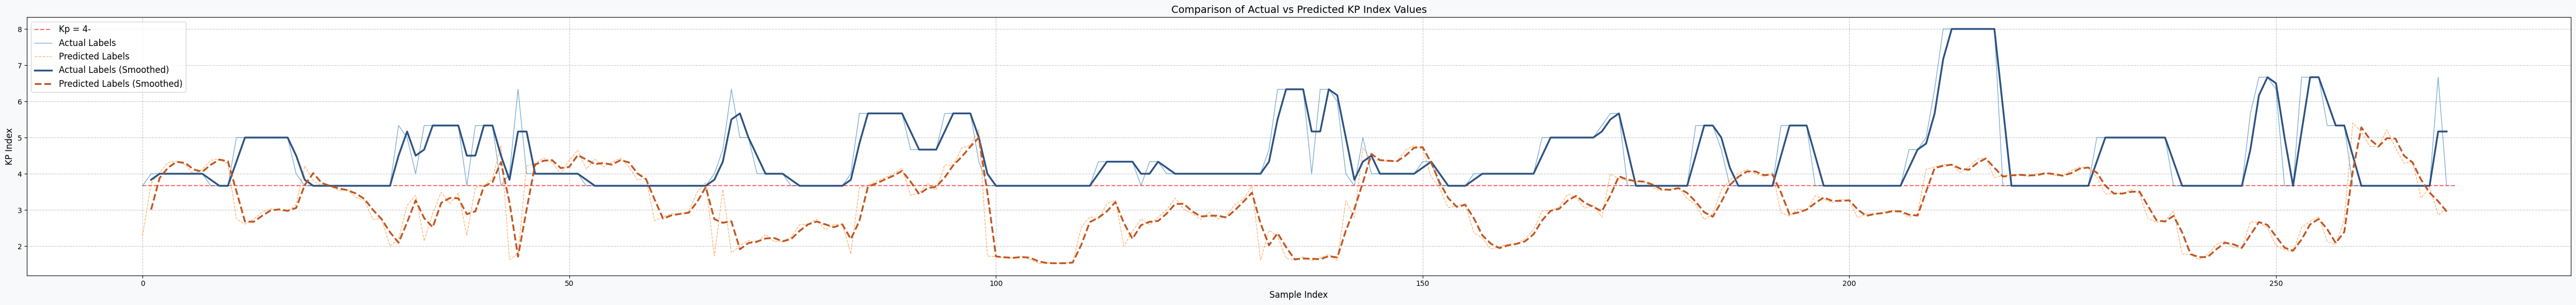

[np.float32(2.28125), np.float32(3.734375), np.float32(4.03125), np.float32(4.3125), np.float32(4.34375), np.float32(4.25), np.float32(3.984375), np.float32(4.125), np.float32(4.375), np.float32(4.40625), np.float32(4.28125), np.float32(2.75), np.float32(2.609375), np.float32(2.734375), np.float32(2.9375), np.float32(3.03125), np.float32(3.0), np.float32(2.953125), np.float32(3.15625), np.float32(4.21875), np.float32(3.8125), np.float32(3.671875), np.float32(3.65625), np.float32(3.53125), np.float32(3.5625), np.float32(3.34375), np.float32(3.265625), np.float32(2.734375), np.float32(2.765625), np.float32(2.0), np.float32(2.1875), np.float32(3.125), np.float32(3.40625), np.float32(2.140625), np.float32(2.90625), np.float32(3.484375), np.float32(3.171875), np.float32(3.46875), np.float32(2.296875), np.float32(3.625), np.float32(3.671875), np.float32(3.859375), np.float32(4.78125), np.float32(1.625), np.float32(1.796875), np.float32(4.21875), np.float32(4.28125), np.float32(4.4375), np.fl

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.239899903120898


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2490994287347417


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4865645194772508


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7384391017876293


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1435136757250335


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1264746195813964


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8928177048502318


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4731406634618343


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7138026202329338


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5207477506913434


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5351496907677671


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.945467722740127


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4674915823135207


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.258837211457355


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.41643049422686534


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.239841103527478


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.34554131487111467


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.69920647119476


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.30596971441706555


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.374802908540376


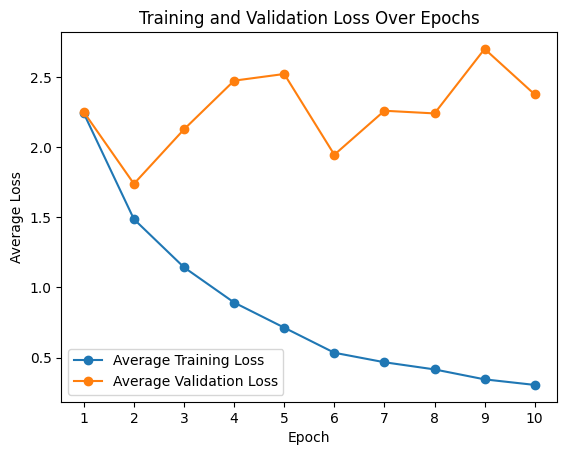

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.3748
RMSE: 1.5410
MSE: 2.3764
MAE: 1.2674
R²: -0.2291
R: 0.2385
True Skill Score: 0.2056
Accuracy: 0.6846
Precision: 0.4295
Recall: 0.4437
F1 Score: 0.4365


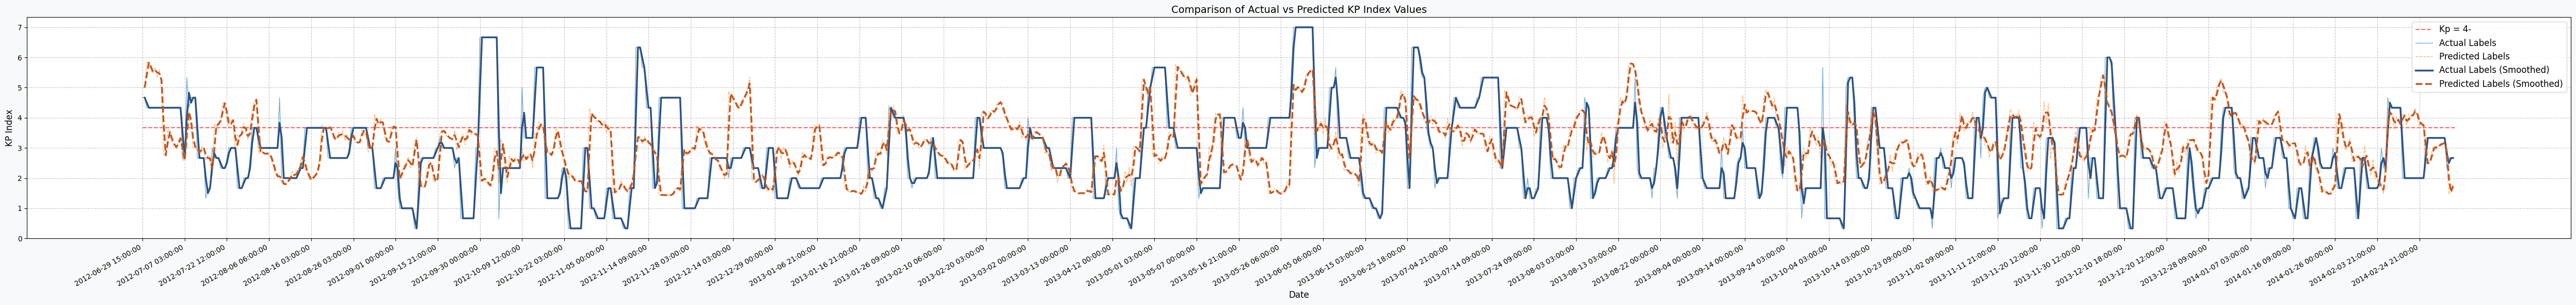

[np.float32(5.0), np.float32(5.0), np.float32(5.84375), np.float32(5.8125), np.float32(5.5625), np.float32(5.46875), np.float32(5.65625), np.float32(5.34375), np.float32(5.59375), np.float32(4.90625), np.float32(2.75), np.float32(2.765625), np.float32(3.625), np.float32(3.4375), np.float32(3.15625), np.float32(3.109375), np.float32(2.953125), np.float32(3.296875), np.float32(3.34375), np.float32(2.609375), np.float32(2.578125), np.float32(4.1875), np.float32(4.1875), np.float32(3.65625), np.float32(3.0), np.float32(3.0625), np.float32(2.921875), np.float32(2.796875), np.float32(3.0625), np.float32(2.953125), np.float32(2.59375), np.float32(2.734375), np.float32(2.578125), np.float32(2.078125), np.float32(3.78125), np.float32(3.671875), np.float32(3.890625), np.float32(3.890625), np.float32(4.46875), np.float32(4.5), np.float32(3.90625), np.float32(3.671875), np.float32(3.921875), np.float32(3.921875), np.float32(2.765625), np.float32(3.4375), np.float32(3.34375), np.float32(3.5625), np

Testing Progress:   0%|          | 0/151 [00:00<?, ?it/s]

Average test loss: 3.0357
RMSE: 1.7423
MSE: 3.0357
MAE: 1.3827
R²: -2.8561
R: 0.0784
True Skill Score: 0.0000
Accuracy: 0.4437
Precision: 1.0000
Recall: 0.4437
F1 Score: 0.6147


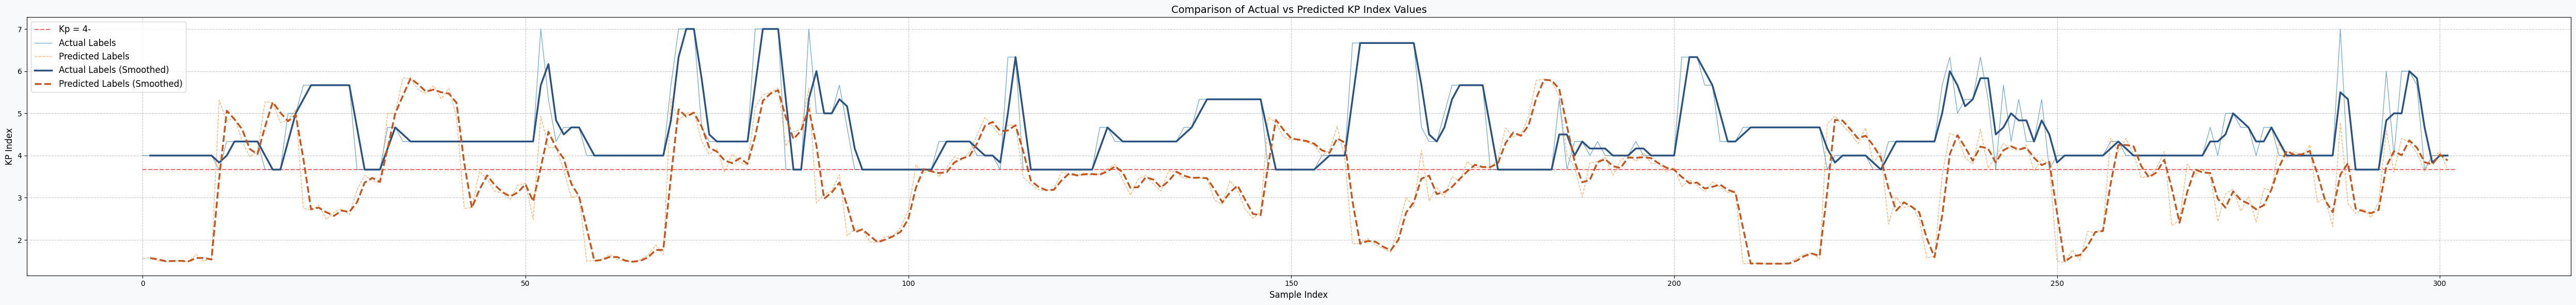

[np.float32(1.5625), np.float32(1.578125), np.float32(1.5), np.float32(1.4921875), np.float32(1.5078125), np.float32(1.5), np.float32(1.484375), np.float32(1.65625), np.float32(1.4921875), np.float32(1.578125), np.float32(5.3125), np.float32(4.8125), np.float32(4.90625), np.float32(4.34375), np.float32(3.96875), np.float32(4.09375), np.float32(5.28125), np.float32(5.25), np.float32(4.78125), np.float32(4.84375), np.float32(5.09375), np.float32(2.75), np.float32(2.703125), np.float32(2.828125), np.float32(2.484375), np.float32(2.65625), np.float32(2.734375), np.float32(2.59375), np.float32(3.1875), np.float32(3.53125), np.float32(3.40625), np.float32(3.34375), np.float32(5.0), np.float32(5.0), np.float32(5.84375), np.float32(5.8125), np.float32(5.5625), np.float32(5.46875), np.float32(5.65625), np.float32(5.34375), np.float32(5.59375), np.float32(4.90625), np.float32(2.75), np.float32(2.765625), np.float32(3.625), np.float32(3.4375), np.float32(3.15625), np.float32(3.109375), np.float32

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.1521295778070693


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9698512514419044


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.516073818606402


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7882974582053415


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1855870246064741


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7749723123422763


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9102488720930372


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8500965197947223


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6940372565933047


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0628318985907583


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5537937495153417


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0131604632842803


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4972410312178465


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0205190993751314


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.41907743715031703


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0770544029913505


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.352318574297576


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8704888837062965


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.31796344371262364


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9886250997253545


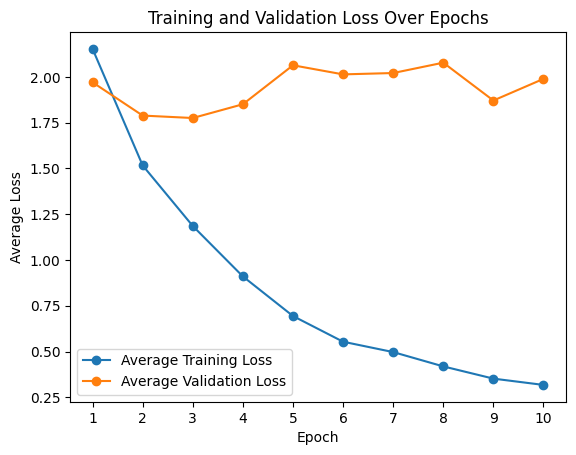

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.9886
RMSE: 1.4102
MSE: 1.9897
MAE: 1.1088
R²: -0.0777
R: 0.2695
True Skill Score: 0.6201
Accuracy: 0.6636
Precision: 0.6818
Recall: 0.2158
F1 Score: 0.3279


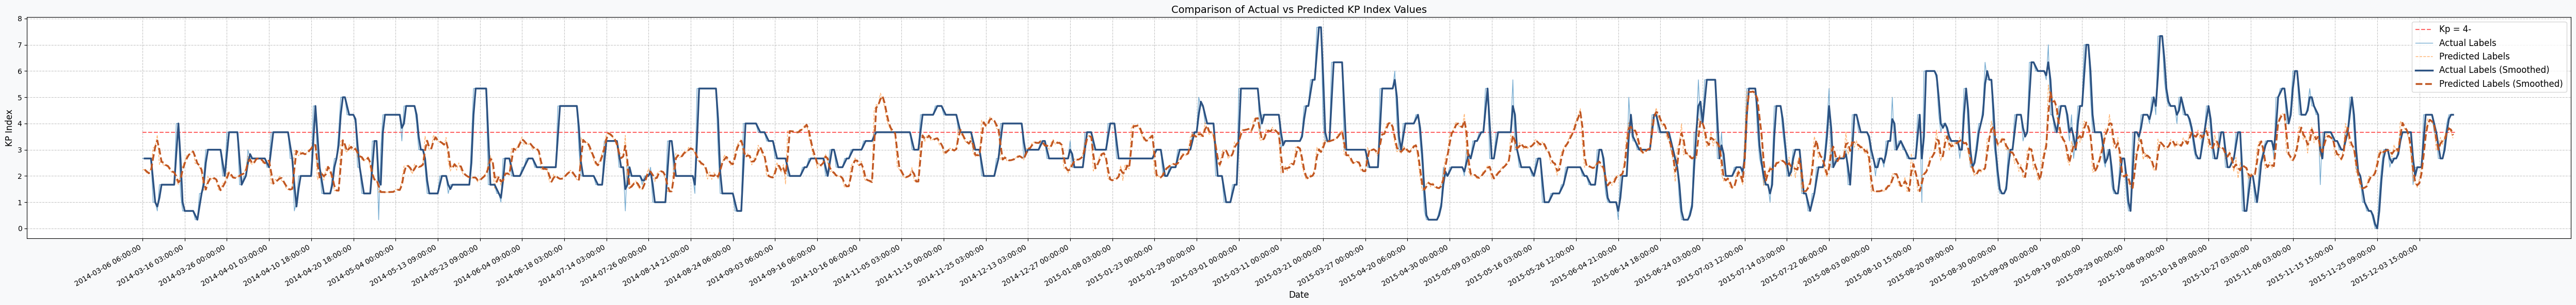

[np.float32(2.234375), np.float32(2.25), np.float32(2.09375), np.float32(2.109375), np.float32(2.296875), np.float32(3.0625), np.float32(3.140625), np.float32(3.5625), np.float32(2.4375), np.float32(2.640625), np.float32(2.375), np.float32(2.453125), np.float32(2.3125), np.float32(2.234375), np.float32(2.125), np.float32(2.140625), np.float32(1.8359375), np.float32(1.671875), np.float32(2.03125), np.float32(2.40625), np.float32(2.546875), np.float32(2.796875), np.float32(2.828125), np.float32(2.875), np.float32(2.984375), np.float32(2.46875), np.float32(2.484375), np.float32(2.328125), np.float32(2.140625), np.float32(1.453125), np.float32(1.5078125), np.float32(1.9765625), np.float32(1.8125), np.float32(1.90625), np.float32(1.9296875), np.float32(1.796875), np.float32(1.484375), np.float32(1.4296875), np.float32(1.7265625), np.float32(1.71875), np.float32(2.109375), np.float32(2.171875), np.float32(1.9375), np.float32(1.9375), np.float32(1.9140625), np.float32(1.9765625), np.float32(2

Testing Progress:   0%|          | 0/209 [00:00<?, ?it/s]

Average test loss: 3.4685
RMSE: 1.8624
MSE: 3.4749
MAE: 1.5548
R²: -3.6889
R: 0.0959
True Skill Score: 0.0000
Accuracy: 0.2158
Precision: 1.0000
Recall: 0.2158
F1 Score: 0.3550


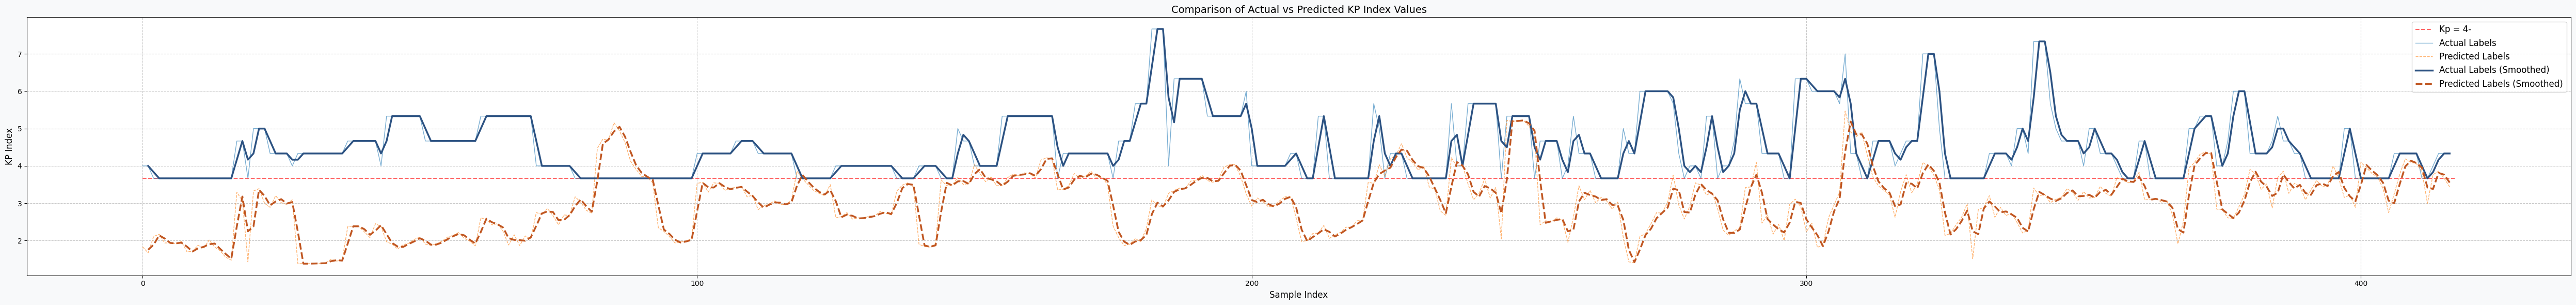

[np.float32(1.8359375), np.float32(1.671875), np.float32(2.109375), np.float32(2.171875), np.float32(1.9375), np.float32(1.9375), np.float32(1.9140625), np.float32(1.9765625), np.float32(1.703125), np.float32(1.7109375), np.float32(1.875), np.float32(1.7890625), np.float32(2.015625), np.float32(1.828125), np.float32(1.7265625), np.float32(1.5546875), np.float32(1.4765625), np.float32(3.296875), np.float32(3.0625), np.float32(1.4296875), np.float32(3.328125), np.float32(3.390625), np.float32(3.0), np.float32(2.890625), np.float32(3.203125), np.float32(3.015625), np.float32(2.96875), np.float32(3.09375), np.float32(1.3828125), np.float32(1.3828125), np.float32(1.3828125), np.float32(1.390625), np.float32(1.390625), np.float32(1.3984375), np.float32(1.5), np.float32(1.453125), np.float32(1.4765625), np.float32(2.375), np.float32(2.390625), np.float32(2.375), np.float32(2.234375), np.float32(2.078125), np.float32(2.453125), np.float32(2.375), np.float32(1.96875), np.float32(1.90625), np.fl

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2592022518322916


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.155360846466619


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.6506672284980612


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5005960441223234


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3292452400378407


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4596390645977644


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0097972703167764


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.445253533489734


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7451035181870965


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4413164077780019


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5855282225244873


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6776916223693934


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4969160146740934


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5793514855942674


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4277518653652797


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5002020244780956


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.372332275849539


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.51737351605055


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.33545098723359734


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5767815877283322


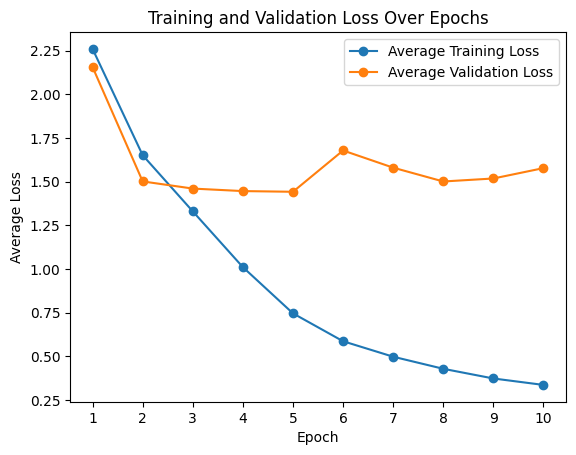

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.5768
RMSE: 1.2557
MSE: 1.5715
MAE: 0.9856
R²: 0.0662
R: 0.4298
True Skill Score: 0.3124
Accuracy: 0.6974
Precision: 0.5953
Recall: 0.6659
F1 Score: 0.6286


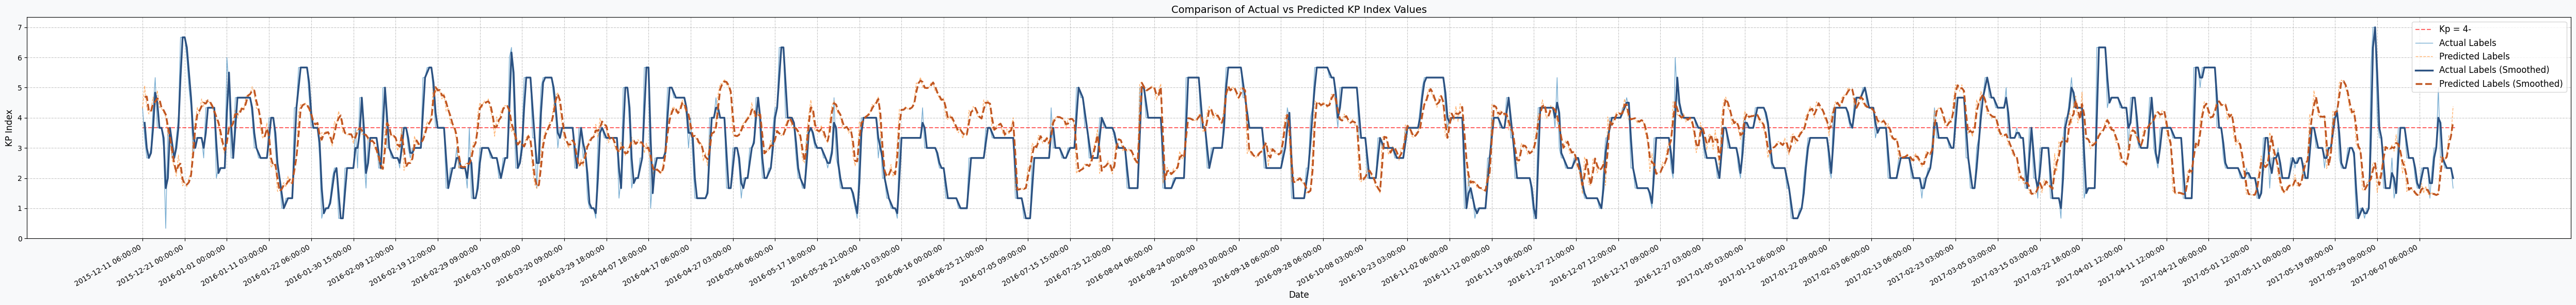

[np.float32(4.3125), np.float32(5.0625), np.float32(4.34375), np.float32(4.125), np.float32(4.28125), np.float32(4.6875), np.float32(4.375), np.float32(4.90625), np.float32(4.34375), np.float32(4.3125), np.float32(4.1875), np.float32(4.03125), np.float32(3.421875), np.float32(3.296875), np.float32(2.609375), np.float32(2.375), np.float32(2.0625), np.float32(2.765625), np.float32(2.1875), np.float32(1.7421875), np.float32(1.8515625), np.float32(1.7109375), np.float32(2.015625), np.float32(2.171875), np.float32(3.390625), np.float32(3.890625), np.float32(4.34375), np.float32(4.125), np.float32(4.625), np.float32(4.375), np.float32(4.5625), np.float32(4.59375), np.float32(4.46875), np.float32(4.34375), np.float32(4.125), np.float32(3.9375), np.float32(3.765625), np.float32(3.296875), np.float32(3.078125), np.float32(2.765625), np.float32(3.609375), np.float32(3.734375), np.float32(3.65625), np.float32(3.984375), np.float32(4.25), np.float32(4.0), np.float32(4.25), np.float32(4.34375), np.

Testing Progress:   0%|          | 0/211 [00:00<?, ?it/s]

Average test loss: 1.5396
RMSE: 1.2408
MSE: 1.5396
MAE: 0.9068
R²: -1.6593
R: 0.0471
True Skill Score: 0.0000
Accuracy: 0.6659
Precision: 1.0000
Recall: 0.6659
F1 Score: 0.7994


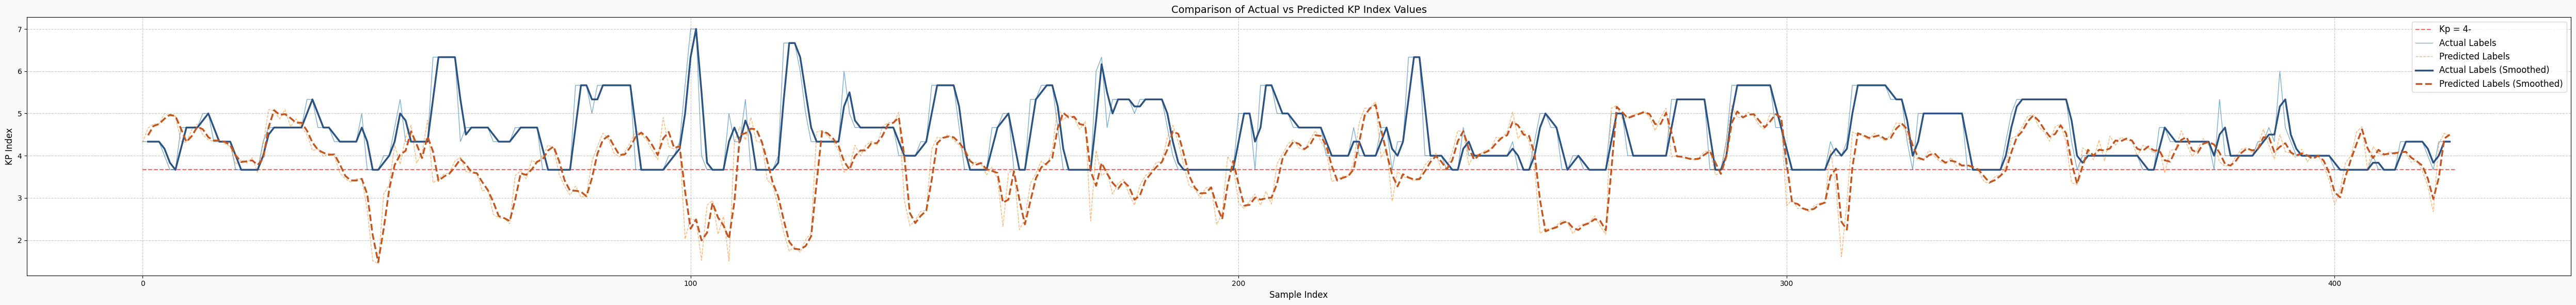

[np.float32(4.3125), np.float32(4.65625), np.float32(4.75), np.float32(4.75), np.float32(5.0), np.float32(4.9375), np.float32(4.9375), np.float32(4.34375), np.float32(4.3125), np.float32(4.625), np.float32(4.75), np.float32(4.5), np.float32(4.375), np.float32(4.34375), np.float32(4.375), np.float32(4.28125), np.float32(4.21875), np.float32(3.796875), np.float32(3.90625), np.float32(3.828125), np.float32(3.953125), np.float32(3.609375), np.float32(4.25), np.float32(5.09375), np.float32(5.0625), np.float32(4.875), np.float32(5.09375), np.float32(4.6875), np.float32(4.875), np.float32(4.6875), np.float32(4.5), np.float32(4.125), np.float32(4.15625), np.float32(3.984375), np.float32(4.0625), np.float32(4.0), np.float32(3.59375), np.float32(3.453125), np.float32(3.375), np.float32(3.453125), np.float32(3.453125), np.float32(2.71875), np.float32(1.515625), np.float32(1.4453125), np.float32(3.09375), np.float32(3.3125), np.float32(4.25), np.float32(3.796875), np.float32(4.4375), np.float32(4.

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.2624282006358127


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4137426218328222


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.6981918233987572


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3967870343944708


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.4042279052250652


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.187347187328659


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.149714882947038


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4012858553038148


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.8838135045206663


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.1537157291332683


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.6771067026760881


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4408940194200046


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5766606165359797


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.7102751994370455


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.4764441939405979


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.30646107825821


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.39237751721257097


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3081050883977547


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3443029064693178


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.306445595472158


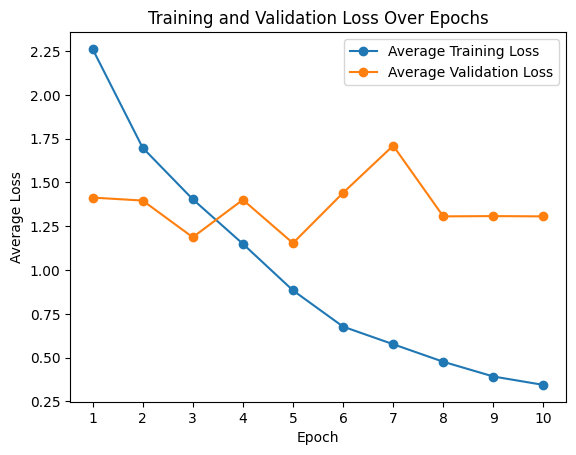

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.3064
RMSE: 1.1430
MSE: 1.3076
MAE: 0.8561
R²: 0.1970
R: 0.5205
True Skill Score: 0.6251
Accuracy: 0.7489
Precision: 0.6750
Recall: 0.2547
F1 Score: 0.3699


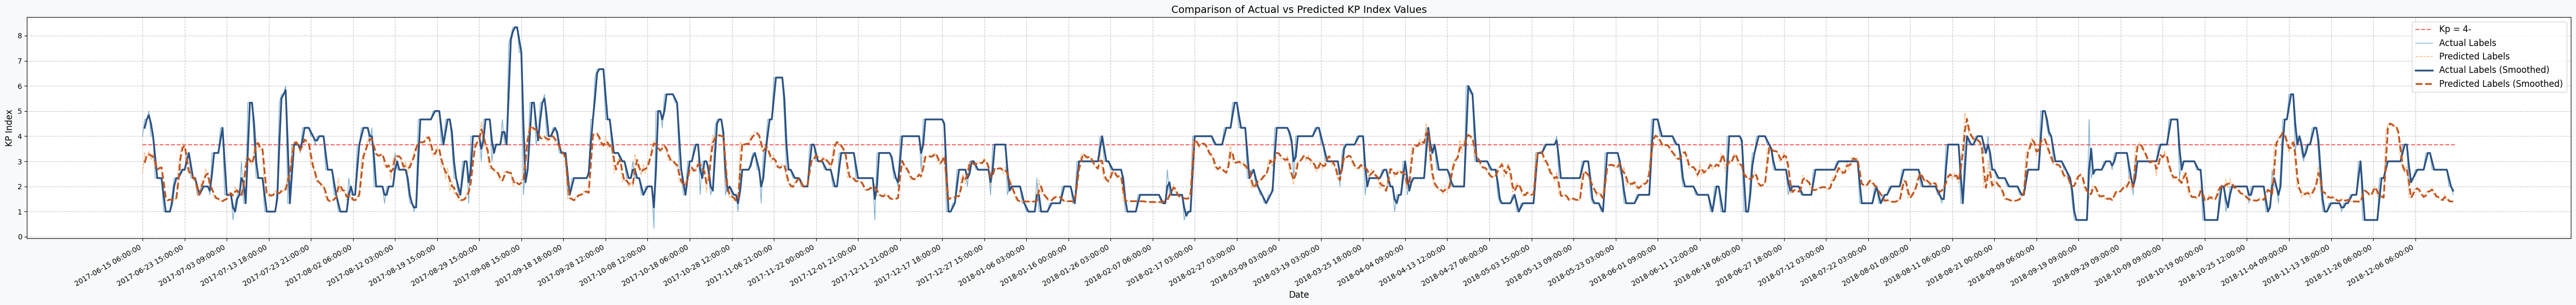

[np.float32(2.53125), np.float32(3.34375), np.float32(3.140625), np.float32(3.40625), np.float32(3.0625), np.float32(3.296875), np.float32(2.671875), np.float32(2.671875), np.float32(2.78125), np.float32(2.734375), np.float32(1.6484375), np.float32(1.453125), np.float32(1.4453125), np.float32(1.515625), np.float32(1.40625), np.float32(1.546875), np.float32(1.46875), np.float32(2.859375), np.float32(3.34375), np.float32(3.71875), np.float32(3.53125), np.float32(2.734375), np.float32(2.484375), np.float32(2.515625), np.float32(2.265625), np.float32(2.25), np.float32(1.6171875), np.float32(1.7421875), np.float32(2.234375), np.float32(2.171875), np.float32(2.71875), np.float32(2.3125), np.float32(1.890625), np.float32(1.8828125), np.float32(1.515625), np.float32(1.5546875), np.float32(1.46875), np.float32(1.421875), np.float32(1.4140625), np.float32(1.515625), np.float32(1.4921875), np.float32(1.765625), np.float32(1.703125), np.float32(1.5859375), np.float32(1.9921875), np.float32(1.71093

Testing Progress:   0%|          | 0/159 [00:00<?, ?it/s]

Average test loss: 2.8339
RMSE: 1.6834
MSE: 2.8339
MAE: 1.3422
R²: -2.8090
R: 0.0758
True Skill Score: 0.0000
Accuracy: 0.2547
Precision: 1.0000
Recall: 0.2547
F1 Score: 0.4060


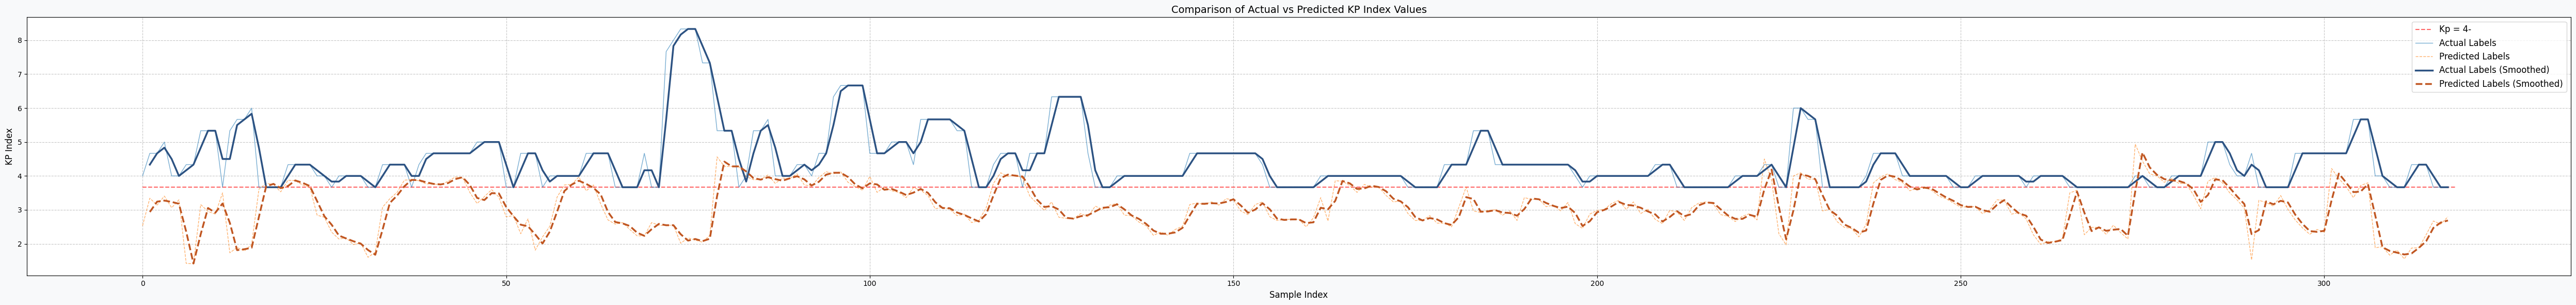

[np.float32(2.53125), np.float32(3.34375), np.float32(3.140625), np.float32(3.40625), np.float32(3.0625), np.float32(3.296875), np.float32(1.421875), np.float32(1.4140625), np.float32(3.15625), np.float32(2.953125), np.float32(2.875), np.float32(3.5), np.float32(1.734375), np.float32(1.890625), np.float32(1.7890625), np.float32(1.9765625), np.float32(3.609375), np.float32(3.78125), np.float32(3.75), np.float32(3.53125), np.float32(3.875), np.float32(3.859375), np.float32(3.734375), np.float32(3.671875), np.float32(2.84375), np.float32(2.78125), np.float32(2.34375), np.float32(2.140625), np.float32(2.171875), np.float32(1.9765625), np.float32(2.03125), np.float32(1.6015625), np.float32(1.75), np.float32(3.078125), np.float32(3.328125), np.float32(3.515625), np.float32(3.875), np.float32(3.890625), np.float32(3.859375), np.float32(3.765625), np.float32(3.765625), np.float32(3.734375), np.float32(3.84375), np.float32(3.96875), np.float32(3.953125), np.float32(3.515625), np.float32(3.1875)

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)


In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
